In this notebook, I approach the house prices competition on Kaggle using XGBoost. This is a powerful ensemble learning method, but seems to have a propensity to overfit. The exploratory data analysis and cleaning is the same as in the basic linear regression notebook, so this is cut and pasted. 

All of my notebooks are work-in-progress, but this one is in particular. I need to come back to it to prevent the extremely strong overfitting which happens if you just run the naive model. 

In [99]:
import numpy as np
import pandas as pd
from math import log
%matplotlib inline 
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')


train_data = pd.read_csv("home-data-for-ml-course/train.csv")
test_data = pd.read_csv("home-data-for-ml-course/test.csv")

pd.set_option('display.max_columns', None)
train_data = train_data.copy()
test_data = test_data.copy()
train_data.set_index('Id')
test_data.set_index('Id');

In the following, it is not necessary to normalise or transform the data, as it was when we used a linear regression model, since we are using XGBoostRegressor, which is based on decision trees. On the other hand, feature selection is important. To start with, I will just throw all the features in with the understanding that it will wildly overfit the data. From there, I can figure out which features are important and refine my model. 

In [100]:
y = train_data.SalePrice
train_data.drop('SalePrice',axis = 1,inplace = True)

In [101]:
categorical_cols = [cname for cname in train_data.columns if train_data[cname].nunique() < 10 and 
                        train_data[cname].dtype == "object"]
numerical_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols
train_data_prepared = train_data[my_cols].copy()

In [102]:
numerical_transformer = SimpleImputer(strategy = 'mean')
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [103]:
"""
Even though GridSearchCV splits the data each time, I have read that it is good pracitce to hold out a little bit just to make
sure that it's not overfitting. We don't need to hold out as much as if we weren't using GridSearchCV though, and don't want to 
hold out so much that the model is trained on an unnecessarily small amount of data. 
"""

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(train_data_prepared, y, train_size = 0.9, random_state = 42)

model = XGBRegressor()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
parameters={'model__gamma' : np.logspace(-2,0,10), 'model__alpha' : np.logspace(-2,0,10)}

gs = GridSearchCV(my_pipeline, param_grid = parameters, scoring = 'neg_mean_squared_error', cv = 5)
gs.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['Id',
                                                                          'MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          '2ndFlrSF',
                                                                          'LowQualFinSF',
                                                                          'GrLivArea',
                                                                          'BsmtFullBath',
                                                                          'BsmtHal...
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'model__alpha': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                         'model__gamma': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])},
             scoring='neg_mean_squared_error')

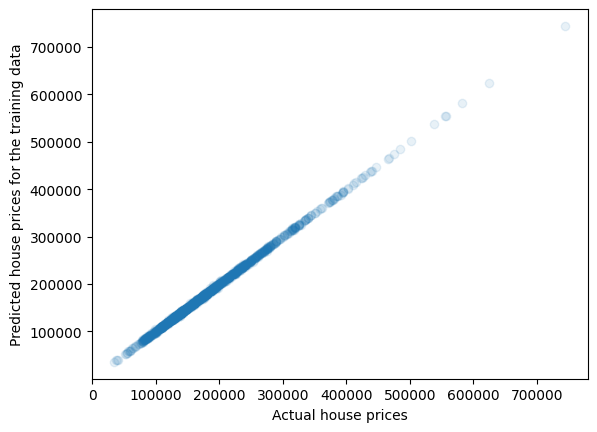

RMSE of the training data is: 0.010305930615037172


In [104]:
gs.best_score_
best_model = gs.best_estimator_
y_predict = best_model.predict(X_train)
RMSE = mean_squared_error(np.log(y_predict), np.log(y_train))**0.5
plt.scatter(y_train, y_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices for the training data")
plt.show()
print(f"RMSE of the training data is: {RMSE}")

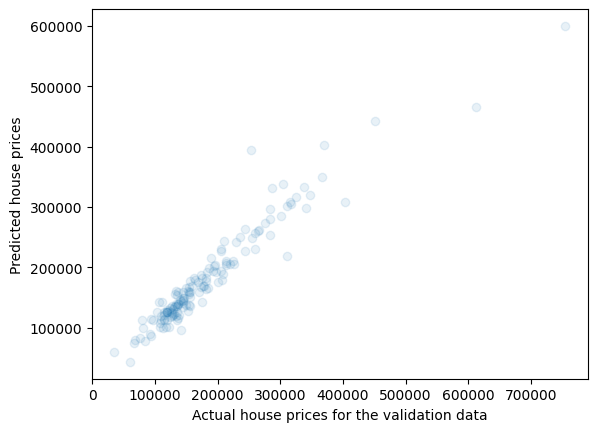

RMSE of the training data is: 0.12717687927970192


In [105]:
y_predict = best_model.predict(X_test)
RMSE = mean_squared_error(np.log(y_predict), np.log(y_test))**0.5
plt.scatter(y_test, y_predict, alpha = 0.1)
plt.xlabel("Actual house prices for the validation data")
plt.ylabel("Predicted house prices")
plt.show()
print(f"RMSE of the training data is: {RMSE}")

This is clearly way way way overfit. As I said at the top though, it would be surprising if it weren't. Things to do in order to create a better model would be:
* decreasing the number of iterations the algorithm goes through.
* Forcing the trees in the model to be shallower. 
* We could decrease the number of samples which each tree is trained on. This, combined with the above points will hopefully prevent the model just learning the output for each individual training data point point.
* By feeding the model all of the data in an unfiltered way, it will almost certainly fit itself to noise in the data. As in the linear regression model, using all of the features is just too complex, and so feature selection is important. Different approaches to this are explained in chapter 3 of Elements of Statistical Learning II.